# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats as st
state = RandomState(12345) 
RANDOM_STATE = 42
TEST_SIZE = 0.25

from matplotlib import pyplot as plt
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error 


Загрузка файлов:

In [2]:
#Первый регион:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

#Второabs регион:
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

#Третий регион:
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


Ознакомимся с информацией в таблицах:

In [3]:
display(geo_data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
display(geo_data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
display(geo_data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Проверим типы данных в таблицах, проверим таблицы на наличие пропусков:

In [7]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Перед проверкой на дубликаты переведем id в индексы.

In [6]:
#Первый регион
geo_data_0 = geo_data_0.set_index('id')
display(geo_data_0.head())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
#Второй регион
geo_data_1 = geo_data_1.set_index('id')
display(geo_data_1.head())

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
#Третий регион
geo_data_2 = geo_data_2.set_index('id')
display(geo_data_2.head())

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Проверим на полные дубликаты:

In [9]:
geo_data_0.duplicated().sum()

0

In [9]:
geo_data_1.duplicated().sum()

0

In [10]:
geo_data_2.duplicated().sum()

0

Проверим на неполные дубликаты: есть ли строки, в которых повторяются все признаки, кроме id (f0, f1, f2 и запасы в скважине).

In [10]:
geo_data_0.loc[geo_data_0.duplicated(['f0', 'f1', 'f2'])]

,f0,f1,f2,product
id,,,,


In [11]:
geo_data_1.loc[geo_data_1.duplicated(['f0', 'f1', 'f2'])]

,f0,f1,f2,product
id,,,,


In [12]:
geo_data_2.loc[geo_data_2.duplicated(['f0', 'f1', 'f2'])]

,id,f0,f1,f2,product


Дубликатов в таблицах нет.

Проведем анализ количественных показателей (объемы запасво скважин) по каждому из трех регионов.  Построим гистограммы и диаграммы размаха для показателей объема запасов скважин.

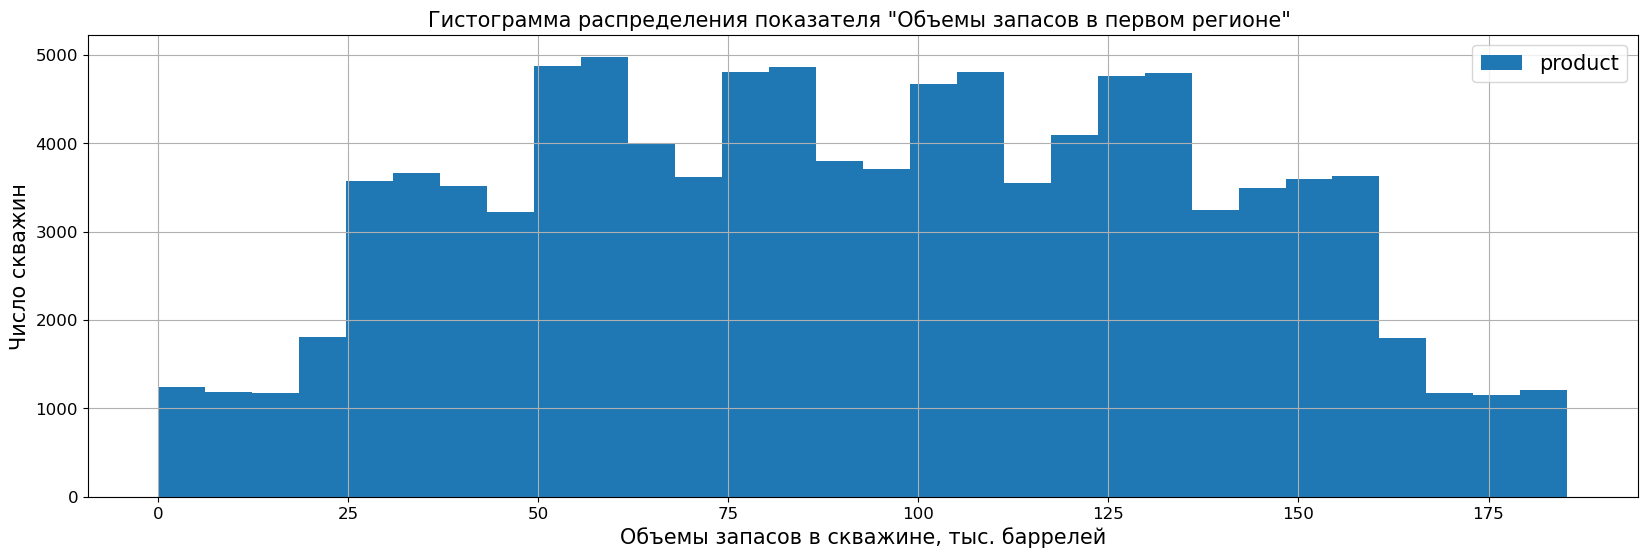

Статистика: count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


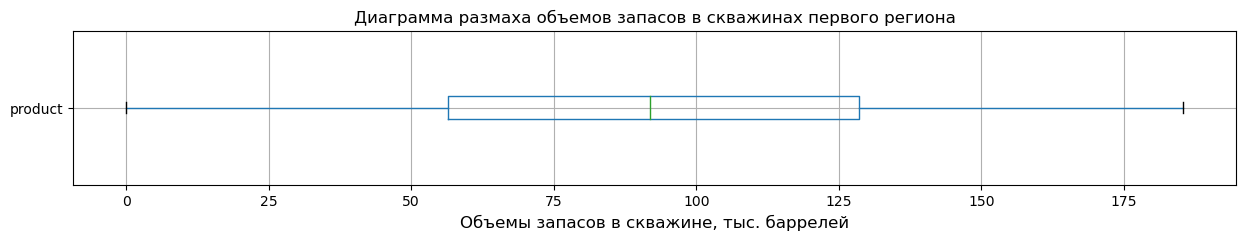

In [10]:
geo_data_0['product'].plot(kind = 'hist', bins = 30, figsize = (20, 6), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Объемы запасов в первом регионе" ', fontsize=15)
plt.xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 15)
plt.ylabel('Число скважин', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = geo_data_0[['product']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха объемов запасов в скважинах первого региона')
ax.set_xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 12)

;

print('Статистика:', geo_data_0['product'].describe())

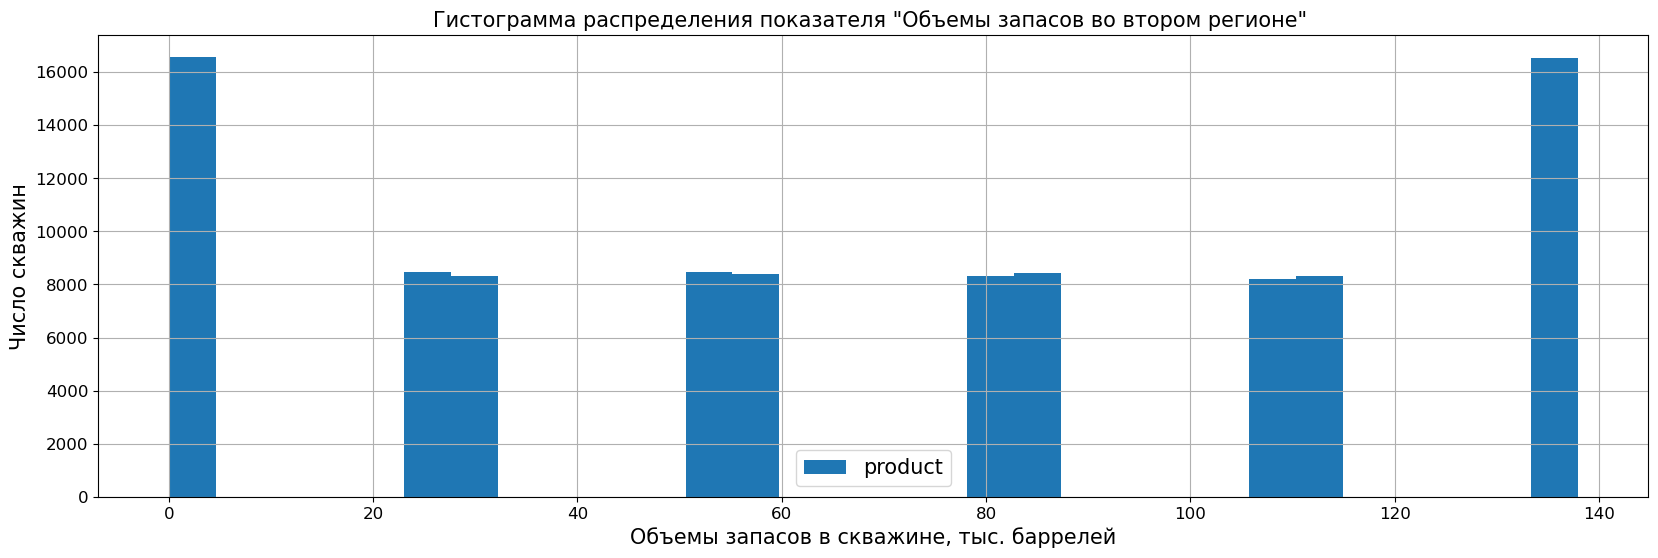

Статистика: count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


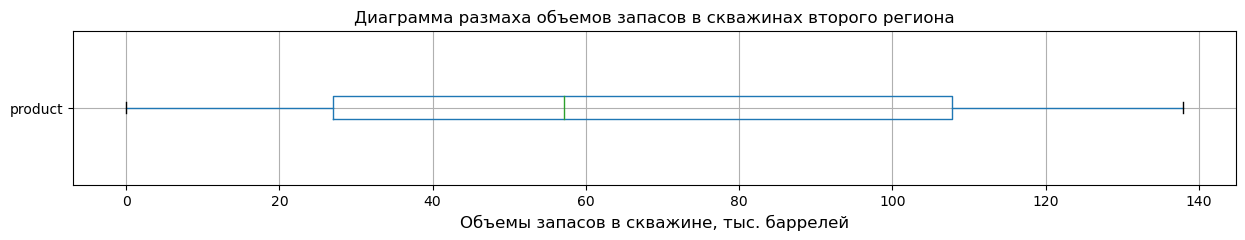

In [11]:
geo_data_1['product'].plot(kind = 'hist', bins = 30, figsize = (20, 6), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Объемы запасов во втором регионе" ', fontsize=15)
plt.xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 15)
plt.ylabel('Число скважин', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = geo_data_1[['product']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха объемов запасов в скважинах второго региона')
ax.set_xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 12)

;

print('Статистика:', geo_data_1['product'].describe())

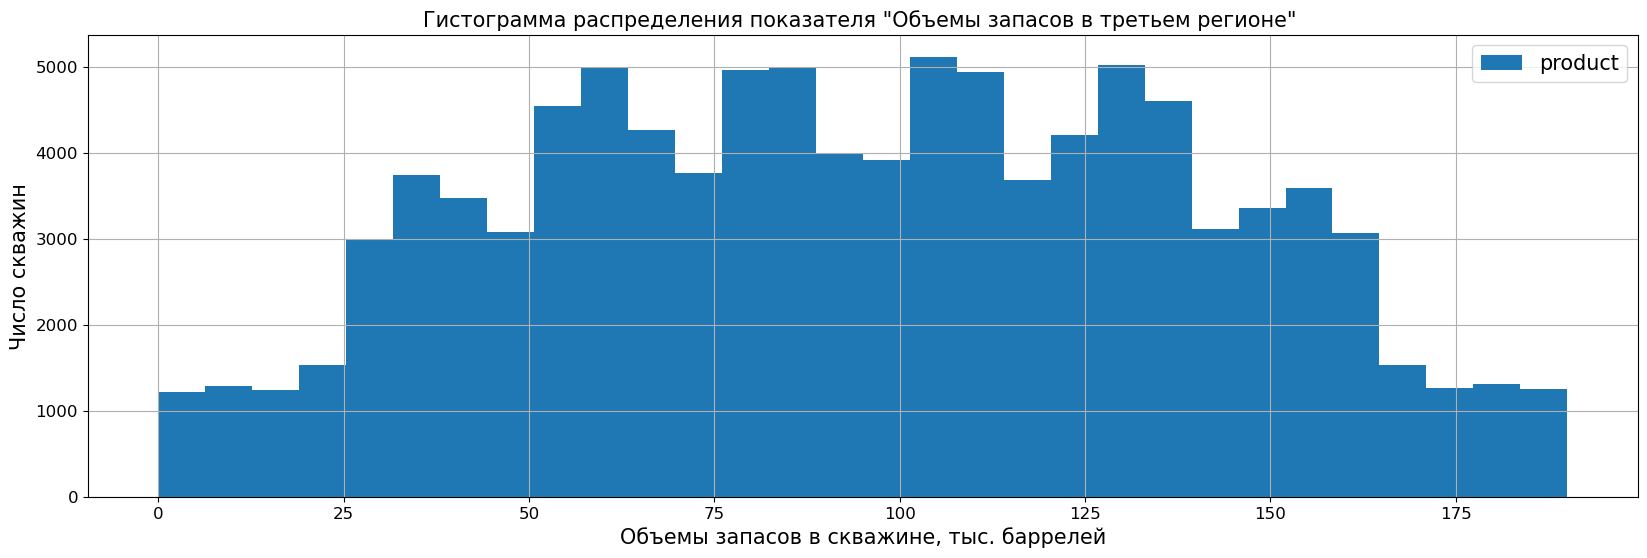

Статистика: count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


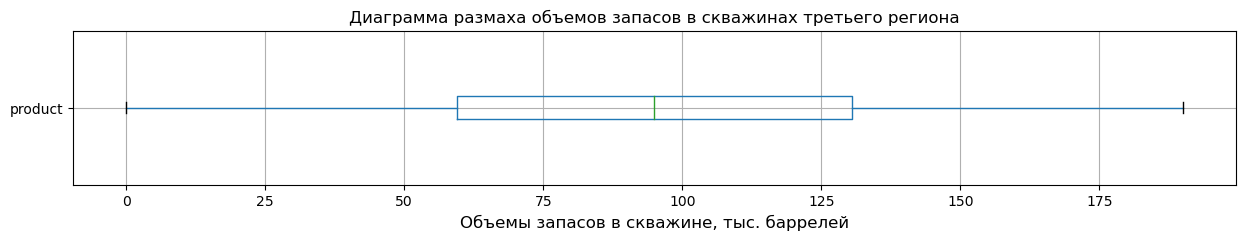

In [12]:
geo_data_2['product'].plot(kind = 'hist', bins = 30, figsize = (20, 6), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Объемы запасов в третьем регионе" ', fontsize=15)
plt.xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 15)
plt.ylabel('Число скважин', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = geo_data_2[['product']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха объемов запасов в скважинах третьего региона')
ax.set_xlabel('Объемы запасов в скважине, тыс. баррелей', fontsize = 12)

;

print('Статистика:', geo_data_2['product'].describe())

**Вывод по исследовательскому анализу данных:**

В 1 и 3 регионах распределения и статистики объемов запасов близки: средние оъемы запасов равны 92 и 95 тыс.баррелей (по 1 и 3 регионам соответственно), стандартное отклонение - 45 тыс.баррелей, максимальный объем запасов - 185 и 190 тыс.баррелей. В данных по 1 и 3 региону просматриваются пики с примерно одинаковой частотой в интервалах около 50, 75, 100, 125 тыс. баррелей.

Во 2 регионе характер распределения данных другой: распределение выглядит дискретным, есть короткие интервалы значений с определенной частотой, и между ними нет промежуточных значений. Это может быть объяснимо несколькими причинами: методом исследования (во 2 регионе, возможно, другие методы измерения запасов, которые дают более точные результаты) или характером залегания ископаемых, особенностями местности. В 1 и 3 регионах ископаемые могут быть распределены иначе, чем во втором. Среднее значение объема запасов во втором регионе почти на 40% меньше (на 36 тыс.баррелей), чем в 1 и 3, среднее отклонение такое же (46 тыс. баррелей), максимальный объем равен 137 тыс.баррелей, что на 28% меньше аналогичного показателя в 1 и 3 регионах.

**Подготовка данных для первого региона.**

Разделим данные на тренировочную и тестовую выборки.

In [13]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
                                             geo_data_0.drop(['product'], axis=1),
                                             geo_data_0['product'],
                                             test_size = TEST_SIZE, 
                                             random_state = RANDOM_STATE
)


Определим перечень столбцов для масштабирования: все столбцы количественные, поэтому кодирования категориальных признаков не требуется. Целевой признак масштабировать не нужно

In [14]:
num_columns = ['f0', 'f1', 'f2']

# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_0_scaled = scaler.fit_transform(X_train_0[num_columns])

# выполним преобразование количественных признаков в валидационной выборке
X_valid_0_scaled = scaler.transform(X_valid_0[num_columns])

# создаём тренировочный и валидационный датафреймы из отмасштабированных данных
X_train_0 = pd.DataFrame(X_train_0_scaled, columns=num_columns)
X_valid_0 = pd.DataFrame(X_valid_0_scaled, columns=num_columns)

Проверим размеры тренировочной и валидационной выборок:

In [15]:
display(X_train_0.shape)
X_valid_0.shape

(75000, 3)

(25000, 3)

Разделили данные по 1 региону на тренировочную и валидационную выборку в соотношении 3:1, все входные признаки количественные, отмасштабировали их с помощью StandardScaler(), проверили корректность разделения данных методом shape.

**Подготовка данных для второго региона.**

Разделим данные на тренировочную и валидационную выборки:

In [16]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
                                             geo_data_1.drop(['product'], axis=1),
                                             geo_data_1['product'],
                                             test_size = TEST_SIZE, 
                                             random_state = RANDOM_STATE
)


In [17]:
num_columns = ['f0', 'f1', 'f2']

# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_1_scaled = scaler.fit_transform(X_train_1[num_columns])

# выполним преобразование количественных признаков в валидационной выборке
X_valid_1_scaled = scaler.transform(X_valid_1[num_columns])

# создаём тренировочный и валидационный датафреймы из отмасштабированных данных
X_train_1 = pd.DataFrame(X_train_1_scaled, columns=num_columns)
X_valid_1 = pd.DataFrame(X_valid_1_scaled, columns=num_columns)

In [18]:
display(X_train_1.shape)
X_valid_1.shape

(75000, 3)

(25000, 3)

Разделили данные по 2 региону на тренировочную и валидационную выборку в соотношении 3:1, все входные признаки количественные, отмасштабировали их с помощью StandardScaler(), проверили корректность разделения данных методом shape.

**Подготовка данных для третьего региона.**

In [20]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
                                             geo_data_2.drop(['product'], axis=1),
                                             geo_data_2['product'],
                                             test_size = TEST_SIZE, 
                                             random_state = RANDOM_STATE
)


In [21]:
num_columns = ['f0', 'f1', 'f2']

# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки 
X_train_2_scaled = scaler.fit_transform(X_train_2[num_columns])

# выполним преобразование количественных признаков в валидационной выборке
X_valid_2_scaled = scaler.transform(X_valid_2[num_columns])

# создаём тренировочный и валидационный датафреймы из отмасштабированных данных
X_train_2 = pd.DataFrame(X_train_2_scaled, columns=num_columns)
X_valid_2 = pd.DataFrame(X_valid_2_scaled, columns=num_columns)

In [22]:
display(X_train_2.shape)
X_valid_2.shape

(75000, 3)

(25000, 3)

Разделили данные по 3 региону на тренировочную и валидационную выборку в соотношении 3:1, все входные признаки количественные, отмасштабировали их с помощью StandardScaler(), проверили корректность разделения данных методом shape.

## Обучение и проверка модели

**Первый регион**

Обучим модель и получим предсказания на валидационной выборке.

In [23]:
# инициализируем модель линейной регрессии
model_lr_0  = LinearRegression() 

# обучим модель на тренировочных данных
model_lr_0.fit(X_train_0, y_train_0) 

# получаем предсказания модели на валидационных данных 
# сохраняем результат в переменную predictions_0
predictions_0 = model_lr_0.predict(X_valid_0)

Создадим таблицу с предскзаниями и фактическими значениями целевого признака валидационной выборки.

In [24]:
#Series с прогнозом объема запасов:
forecast_series_0 = pd.Series(predictions_0)
print(forecast_series_0.head())

0    101.901017
1     78.217774
2    115.266901
3    105.618618
4     97.980185
dtype: float64


Сделаем из объекта Series объект DataFrame:

In [25]:
forecast_geo_data_0 = forecast_series_0.to_frame(name='product_prognose')
display(forecast_geo_data_0.head())


,product_prognose
0,101.901017
1,78.217774
2,115.266901
3,105.618618
4,97.980185


Добавим столбец с фактическими значениями объемов запасов из валидационной выборки.

In [26]:
y_valid_0.head()

id
7C6bA    122.073350
dVxsn     48.738540
1Gm3l    131.338088
Nzg1t     88.327757
Z7b4F     36.959266
Name: product, dtype: float64

Сделам из Series с фактическими объемами запасов объект DataFrame:

In [27]:
y_valid_0_frame = y_valid_0.to_frame(name='product_fact')
y_valid_0_frame.head()

,product_fact
id,
7C6bA,122.073350
dVxsn,48.738540
1Gm3l,131.338088
Nzg1t,88.327757
Z7b4F,36.959266


Добавим столбец с id в таблицу с прогнозом для дальнейшего объединения.

In [28]:
forecast_geo_data_0['id'] = y_valid_0.index
display(forecast_geo_data_0.head())

,product_prognose,id
0,101.901017,7C6bA
1,78.217774,dVxsn
2,115.266901,1Gm3l
3,105.618618,Nzg1t
4,97.980185,Z7b4F


Переведем id в индекс

In [29]:
forecast_geo_data_0 = forecast_geo_data_0.set_index('id')
display(forecast_geo_data_0.head())

,product_prognose
id,
7C6bA,101.901017
dVxsn,78.217774
1Gm3l,115.266901
Nzg1t,105.618618
Z7b4F,97.980185


Добавим столбец с фактическими объемами запасов из фрейма y_valid_0 в таблицу с прогнозом.

In [30]:
forecast_geo_data_0['product_fact'] = y_valid_0_frame['product_fact']
forecast_geo_data_0.head()

,product_prognose,product_fact
id,,
7C6bA,101.901017,122.073350
dVxsn,78.217774,48.738540
1Gm3l,115.266901,131.338088
Nzg1t,105.618618,88.327757
Z7b4F,97.980185,36.959266


Посчитаем средний запас предсказанного сырья и RMSE модели:

In [31]:
prognose_mean = round(forecast_geo_data_0['product_prognose'].mean(), 2)
fact_mean = round(forecast_geo_data_0['product_fact'].mean(), 2)

rmse = mean_squared_error(forecast_geo_data_0['product_fact'], forecast_geo_data_0['product_prognose'], squared = False) 

print('Средний запас предсказанного сырья: ', prognose_mean, ' тыс. баррелей', '\n',
      'Среднее фактическое значение объемов сырья: ', fact_mean, ' тыс. баррелей', '\n',
     'RMSE модели: ', round(rmse, 2))

Средний запас предсказанного сырья:  92.4  тыс. баррелей 
 Среднее фактическое значение объемов сырья:  92.33  тыс. баррелей 
 RMSE модели:  37.76


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


***Вывод по расчетам модели для первого региона:*** 

По итогам расчета модели мы получили средний прогноз объема сырья 92,4 тыс. баррелей и достачтоно высокое значение RMSE - 37,76 тыс.баррелей. Т е в среднем модель ошибается на 37,76 тыс. баррелей, что составляет почти 41% от среднего значения прогноза.

**Второй регион**

Обучим модель и получим предсказания на валидационной выборке.

In [32]:
# обучим модель на тренировочных данных
model_lr_0.fit(X_train_1, y_train_1) 

# получаем предсказания модели на валидационных данных 
# сохраняем результат в переменную predictions_0
predictions_1 = model_lr_0.predict(X_valid_1)

Создадим таблицу с предскзаниями и фактическими значениями целевого признака валидационной выборки.

In [33]:
#Series с прогнозом объема запасов:
forecast_series_1 = pd.Series(predictions_1)
print(forecast_series_1.head())

0      0.844738
1     52.921612
2    135.110385
3    109.494863
4     -0.047292
dtype: float64


In [34]:
forecast_geo_data_1 = forecast_series_1.to_frame(name='product_prognose')
display(forecast_geo_data_1.head())

,product_prognose
0,0.844738
1,52.921612
2,135.110385
3,109.494863
4,-0.047292


Добавим столбец с фактическими значениями объемов запасов из валидационной выборки.

In [35]:
y_valid_1_frame = y_valid_1.to_frame(name='product_fact')
y_valid_1_frame.head()

,product_fact
id,
fYVDK,0.000000
3SQcq,53.906522
hQ1gJ,134.766305
Y4vux,107.813044
H1NUw,0.000000


Добавим в таблицу с прогнозом столбец с id и переведем id в индекс

In [36]:
forecast_geo_data_1['id'] = y_valid_1.index
forecast_geo_data_1 = forecast_geo_data_1.set_index('id')
display(forecast_geo_data_1.head())

,product_prognose
id,
fYVDK,0.844738
3SQcq,52.921612
hQ1gJ,135.110385
Y4vux,109.494863
H1NUw,-0.047292


Добавим столбец с фактическим объемом запасов из y_valid_1 в таблицу с прогнозом:

In [37]:
forecast_geo_data_1['product_fact'] = y_valid_1_frame['product_fact']
forecast_geo_data_1.head()

,product_prognose,product_fact
id,,
fYVDK,0.844738,0.000000
3SQcq,52.921612,53.906522
hQ1gJ,135.110385,134.766305
Y4vux,109.494863,107.813044
H1NUw,-0.047292,0.000000


Посчитаем средний прогноз запасов сырья и RMSE модели

In [38]:
prognose_mean_1 = round(forecast_geo_data_1['product_prognose'].mean(), 2)
fact_mean_1 = round(forecast_geo_data_1['product_fact'].mean(), 2)

rmse_1 = mean_squared_error(forecast_geo_data_1['product_fact'], forecast_geo_data_1['product_prognose'], squared = False) 

print('Средний запас предсказанного сырья: ', prognose_mean_1, ' тыс. баррелей', '\n',
      'Среднее фактическое значение объемов сырья: ', fact_mean_1, ' тыс. баррелей', '\n',
     'RMSE модели: ', round(rmse_1, 2))

Средний запас предсказанного сырья:  68.71  тыс. баррелей 
 Среднее фактическое значение объемов сырья:  68.73  тыс. баррелей 
 RMSE модели:  0.89


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


***Вывод по расчетам модели для второго региона:***

По итогам расчета модели мы получили средний прогноз объема сырья 68,71 тыс. баррелей и низкое значение RMSE - 0,89 тыс.баррелей. Т е в среднем модель ошибается всего на 0,89 тыс. баррелей. Прогноз объемов существенно ниже, чем в первом регионе, но ошибка составляет всего 1,3% от среднего значения (в прогнозе по первому региону ошибка составляла почти 41% от среднего значения.

**Третий регион**

Делаем по аналогии с предыдущими.

In [39]:
# обучим модель на тренировочных данных
model_lr_0.fit(X_train_2, y_train_2) 

# получаем предсказания модели на валидационных данных 
# сохраняем результат в переменную predictions_0
predictions_2 = model_lr_0.predict(X_valid_2)

In [40]:
#Series с прогнозом объема запасов:
forecast_series_2 = pd.Series(predictions_2)
forecast_geo_data_2 = forecast_series_2.to_frame(name='product_prognose')
display(forecast_geo_data_2.head())

,product_prognose
0,98.301916
1,101.592461
2,52.449099
3,109.922127
4,72.411847


In [41]:
y_valid_2_frame = y_valid_2.to_frame(name='product_fact')
forecast_geo_data_2['id'] = y_valid_2.index
forecast_geo_data_2 = forecast_geo_data_2.set_index('id')
display(forecast_geo_data_2.head())

,product_prognose
id,
sPjbT,98.301916
1u4uo,101.592461
kZ6HO,52.449099
gCZGK,109.922127
rqJHx,72.411847


In [42]:
forecast_geo_data_2['product_fact'] = y_valid_2_frame['product_fact']
forecast_geo_data_2.head()

,product_prognose,product_fact
id,,
sPjbT,98.301916,117.441301
1u4uo,101.592461,47.841249
kZ6HO,52.449099,45.883483
gCZGK,109.922127,139.014608
rqJHx,72.411847,84.004276


Посчитаем средний прогноз запасов сырья и RMSE модели

In [43]:
prognose_mean_2 = round(forecast_geo_data_2['product_prognose'].mean(), 2)
fact_mean_2 = round(forecast_geo_data_2['product_fact'].mean(), 2)

rmse_2 = mean_squared_error(forecast_geo_data_2['product_fact'], forecast_geo_data_2['product_prognose'], squared = False) 

print('Средний запас предсказанного сырья: ', prognose_mean_2, ' тыс. баррелей', '\n',
      'Среднее фактическое значение объемов сырья: ', fact_mean_2, ' тыс. баррелей', '\n',
     'RMSE модели: ', round(rmse_2, 2))

Средний запас предсказанного сырья:  94.77  тыс. баррелей 
 Среднее фактическое значение объемов сырья:  95.15  тыс. баррелей 
 RMSE модели:  40.15


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


***Вывод по расчетам модели для третьего региона:*** 

По итогам расчета модели мы получили средний прогноз объема сырья 94.77 тыс. баррелей и достаточно высокое значение RMSE - 40,15 тыс.баррелей. Т е в среднем модель ошибается на 40,15 тыс. баррелей, что составляет 42,4% от среднего значения прогноза.

Посчитаем r2 (коэффициент детерминации) модели для трех регионов, чтобы посмотреть, насколько предсказания модели точнее/хуже расчетного среднего значения. Построим гистограмму распределения остатков (разницы между фактом и прогнозом) и диаграмму рассеяния ошибок модели.

***Расчет  r2 для первого региона***

In [44]:
r2_0 = r2_score(forecast_geo_data_0['product_fact'], forecast_geo_data_0['product_prognose']) 
print(f'Коэффициент детерминации модели для 1 региона равен  {r2_0:.4f}')

Коэффициент детерминации модели для 1 региона равен  0.2728


Всего в 27,3% случаев предсказание модели ближе к истине, чем среднее значение целевого признака, а в 72,8% случаев точнее среднее значение целевого признака, чем предсказание модели. Т е для расчета прогноза по первому региону лучше использовать просто среднее значение целевого признака валидационной выборки. 

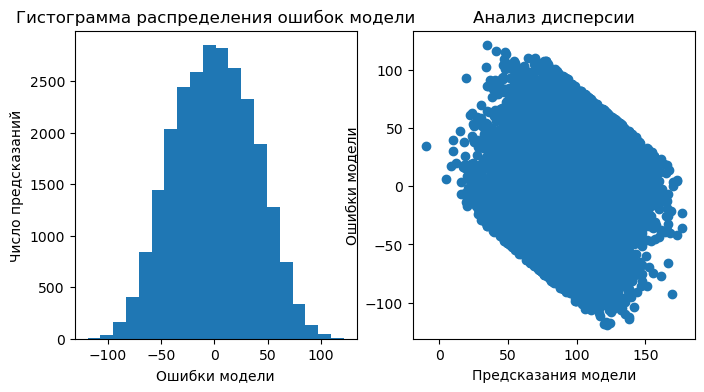

In [47]:
#Рассчитаем остатки
residuals_0 = forecast_geo_data_0['product_fact'] - forecast_geo_data_0['product_prognose']

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].hist(residuals_0, bins = 20)
axes[0].set_title('Гистограмма распределения ошибок модели')
axes[0].set_xlabel('Ошибки модели')
axes[0].set_ylabel('Число предсказаний')

axes[1].scatter(x = forecast_geo_data_0['product_prognose'], y = residuals_0)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Ошибки модели')
axes[1].set_title('Анализ дисперсии')
plt.show()

***Распределение ошибок модели***

Ошибки модели имеют распределение, близкое к нормульному, график почти симметричен относительно нуля, максимльное значение остатков модели варьируется от -50 до +50. Модель даёт как завышенные, так и заниженные предсказания, и достаточно много (график достаточно широкий).

***Анализ дисперсии ошибок***

В качественной модели разница между минимумом и максимумом ошибок при любых прогнозных значениях модели должна быть постоянной, т е модель должна равномерно ошибаться. На этой диаграмме рассеяния видно, что дисперсия между значениями на оси Y не стабильна: она уменьшается по мере роста предскзаний.

***Расчет r2 для второго региона.***

In [48]:
r2_1 = r2_score(forecast_geo_data_1['product_fact'], forecast_geo_data_1['product_prognose']) 
print(f'Коэффициент детерминации модели для 2 региона равен  {r2_1:.4f}')

Коэффициент детерминации модели для 2 региона равен  0.9996


Почти в 100% случаев предсказание модели ближе к истине, чем среднее значение целевого признака из валидационной выборки. Т е для расчета прогноза по второму региону можно полагаться на прогнозы модели.

Сделаем анализ ошибок модели, построим гистограмму и диаграмму рассеяния.

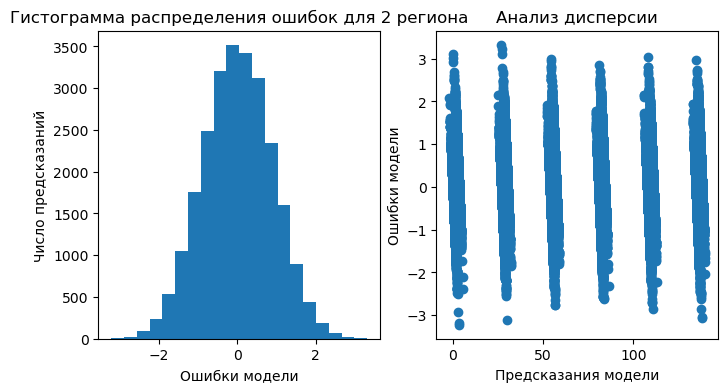

In [50]:
#Рассчитаем остатки
residuals_1 = forecast_geo_data_1['product_fact'] - forecast_geo_data_1['product_prognose']

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].hist(residuals_1, bins = 20)
axes[0].set_title('Гистограмма распределения ошибок для 2 региона')
axes[0].set_xlabel('Ошибки модели')
axes[0].set_ylabel('Число предсказаний')

axes[1].scatter(x = forecast_geo_data_1['product_prognose'], y = residuals_1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Ошибки модели')
axes[1].set_title('Анализ дисперсии')
plt.show()

Ошибки распределены нормально, и значения ошибок ничтожно малы по сравнению со значениями прогнозов: +/- максимум 3 тыс баррелей. Ошибки по 1 региону имеют достигают более 100 тыс. баррелей в обе стороны (в сторону занижения и завышения).

***Расчет r2 для 3 региона***

In [51]:
r2_2 = r2_score(forecast_geo_data_2['product_fact'], forecast_geo_data_2['product_prognose']) 
print(f'Коэффициент детерминации модели для 3 региона равен  {r2_2:.4f}')

Коэффициент детерминации модели для 3 региона равен  0.1963


Всего в 19,6% случаев предсказание модели ближе к истине, чем среднее значение целевого признака, а в 80,4% случаев точнее среднее значение целевого признака, чем предсказание модели. Для расчета прогноза по третьему региону лучше использовать просто среднее значение целевого признака валидационной выборки.

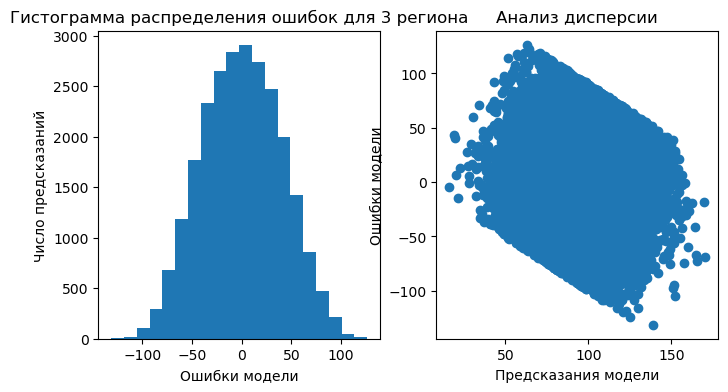

In [53]:
#Рассчитаем остатки
residuals_2 = forecast_geo_data_2['product_fact'] - forecast_geo_data_2['product_prognose']

# построим гистограмму распределения количественных признаков и диаграмму рассеяния

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].hist(residuals_2, bins = 20)
axes[0].set_title('Гистограмма распределения ошибок для 3 региона')
axes[0].set_xlabel('Ошибки модели')
axes[0].set_ylabel('Число предсказаний')

axes[1].scatter(x = forecast_geo_data_2['product_prognose'], y = residuals_2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Ошибки модели')
axes[1].set_title('Анализ дисперсии')
plt.show()

***Распределение ошибок модели***

Аналогично распредлению дяя 1 региона. Ошибки модели имеют распределение, близкое к нормульному, график почти симметричен относительно нуля, максимльное значение остатков модели варьируется от -50 до +50. Модель даёт как завышенные, так и заниженные предсказания, и достаточно много (график достаточно широкий).

***Анализ дисперсии ошибок***

В качественной модели разница между минимумом и максимумом ошибок при любых прогнозных значениях модели должна быть постоянной, т е модель должна равномерно ошибаться. На этой диаграмме рассеяния видно, что дисперсия между значениями на оси Y не стабильна: она уменьшается по мере роста предскзаний.

**Общий вывод по расчетам модели для трех регионов:**

Средний прогноз объемов нефти для 1 региона - 92,4 тыс. баррелей, RMSE модели - 37,76 тыс. баррелей.
Для 2 региона - средний прогноз 68,71 тыс. баррелей, RMSE - 0,89 тыс.баррелей.
Для 3 региона - средний прогноз 94,8 тыс. баррелей, RMSE  - 40,15 тыс. баррелей.

В 1 и 3 регионе при высоких средних значениях прогнозов получились достаточно высокие средние ошибки модели, низкие коэффициенты детерминации. Для 1 и 3 региона примерно в 80% случаев точнее будет использовать среднее значение целевого признака валидационой выборки, чем прогнозы модели.

Во 2 регионе средний прогноз запасов ощутимо ниже, чем в 1 и 3 регионах, но расчеты прогнозы почти в 100% случаев точнее средних значений целевого признака валидационной выборки. 

## Подготовка к расчёту прибыли

Сохраним значения для расчетов в отдельных переменных:

In [54]:
#Бюджет на разоработку:
BUDGET = 10_000_000_000

#доход с едлиницы сырья:
INCOME_PER_UNIT = 450000

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Чтобы разработка скважины имела экономический смысл, нужно, чтобы объем запасов ***одной*** скважины был больше бюджета (1 млрд разделить на 200, т к бюджет направлен на разработку 200 лучших скважин из региона), разделенного на доход с елиницы сырья (450 тыс. руб. с 1 тыс баррелей)

In [55]:
product_adequate = ((BUDGET/200)/INCOME_PER_UNIT)
print('Объем сырья, достаточный для безубыточной работы новой скважины: ', round(product_adequate, 3), 'тыс. баррелей. ')

Объем сырья, достаточный для безубыточной работы новой скважины:  111.111 тыс. баррелей. 


Сравним полученный достаточный объем сырья со средними значениями запасов в каждом регионе. 

Для **1** и **3** регионов будем считать разницу между средним объемом фактических запасов (т к для данных моделей среднее значение факта точнее прогноза моделей) и достаточным объемом сырья, для **2** региона будем считать разницу между средним прогнозным значением и достаточным объемом сырья.


In [56]:
difference_0 = fact_mean - product_adequate
print(f'В первом регионе средний объем запасов на {abs(difference_0):.2f} тыс. баррелей меньше достаточного для разработки объема')

difference_1 = prognose_mean_1 - product_adequate
print(f'Во втором регионе средний объем запасов на {abs(difference_1):.2f} тыс. баррелей меньше достаточного для разработки объема')

difference_2 = fact_mean_2 - product_adequate
print(f'Во втором регионе средний объем запасов на {abs(difference_2):.2f} тыс. баррелей меньше достаточного для разработки объема')


В первом регионе средний объем запасов на 18.78 тыс. баррелей меньше достаточного для разработки объема
Во втором регионе средний объем запасов на 42.40 тыс. баррелей меньше достаточного для разработки объема
Во втором регионе средний объем запасов на 15.96 тыс. баррелей меньше достаточного для разработки объема


**Вывод по подготовке к расчету прибыли:**

Во всех трех регионах средний объем запасов меньше объема, достаточного для экономической целесообразности разработки. В первом и третьем регионах расчетный экономический эффект чуть лучше, но при разработке скважин со средним объемом все равно получаются убытки, хоть и меньшие, чем во тором регионе.
Если в 1 и 3 регионах учитывать разброс значений объемов сырья и взять скважины с объемом запасов, большим, чем средний, хотя бы на 20 тыс баррелей, то эти скважины можно взять в разработку: средний объем запасов в 1 и 3 регионе составляет 92-95 тыс. баррелей, если брать скважины с запасами хотя бы на 20 тыс.баррелей превышающими среднее значение, то получим безубыточные варианты. 

Во 2 регионе средний объем запасов  - 57 тыс. баррелей. Для безубыточной разработки нужно взять скважины с объемами,хотя бы в 2 раза превышающими среднее значение. Если смотреть на статистику, рассчитанную в исследовательском анализе данных, менее 25% всех скважин удовлетворяют условию безубыточности: 75% квантиль раен 107 тыс.баррелей, что ниже точки безубыточности.

Поскольку скважин 10 тыс., то несмотря на низкие средние значения объемов запасов во 2 регионе, в нем возможно найти 200 точек, проходящих условие безубыточности. Т к прогнозы по 2 региону существенно более точные, чем по 1 и 3, то экономически безопаснее делать ставку на 2 регион.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [57]:
def profit(data):
    sorted_data = data.sort_values(by = 'product_prognose', ascending = False) #выбираем топ-200 точек по прогнозам
    profit = sorted_data['product_fact'][0:200].sum()*INCOME_PER_UNIT - BUDGET #считаем прибыль по фактическим значениям 
    return(profit)

In [58]:
forecast_geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, fYVDK to cQudG
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_prognose  25000 non-null  float64
 1   product_fact      25000 non-null  float64
dtypes: float64(2)
memory usage: 1.1+ MB


**Первый регион:**


Посчитаем значения прибыли по выбранным топ-200 скважинам, для расчетов будем использовать не прогнозные, а фактические значения запасов:

In [59]:
profit_0 = profit(forecast_geo_data_0)
print(round(profit_0, 1))
print('Фактическая прибыль для 1 региона: ', round((profit_0/1000000000), 2), 'млрд. рублей.' )

3359141114.5
Фактическая прибыль для 1 региона:  3.36 млрд. рублей.


Посчитаем прибыль, рассчитанную не на фактических, а на прогнозных значениях запасов:

In [60]:
reg_0_top_200 = forecast_geo_data_0.sort_values(by = 'product_prognose', ascending = False)[:200]

In [61]:
profit_0_prognose = reg_0_top_200['product_prognose'].sum()*INCOME_PER_UNIT - BUDGET
print(round(profit_0_prognose, 1))
print('Прогноз прибыли для 1 региона: ', round((profit_0_prognose/1000000000), 2), 'млрд. рублей.' )

3896658479.7
Прогноз прибыли для 1 региона:  3.9 млрд. рублей.


По итогам расчета прибыли в 1 регионе можно сделать вывод, что прибыль, посчитанная на прогнозных данных, выше фактической прибыли более чем на полмиллиарда рублей (на 16% или на 0.54 млрд.руб.). Т е если использовать данные модели для прогноза в регионах, схожих с первым, есть большая вероятность получить завышенные прогнозы.

**Второй регион:**


In [62]:
profit_1 = profit(forecast_geo_data_1)
print(round(profit_1, 2))
print('Фактическая прибыль для 2 региона: ', round((profit_1/1000000000), 2), 'млрд. рублей.' )

2415086696.68
Фактическая прибыль для 2 региона:  2.42 млрд. рублей.


Посчитаем прибыль на прогнозных данных.

In [63]:
reg_1_top_200 = forecast_geo_data_1.sort_values(by = 'product_prognose', ascending = False)[:200]

In [64]:
profit_1_prognose = reg_1_top_200['product_prognose'].sum()*INCOME_PER_UNIT - BUDGET
print(round(profit_1_prognose, 2))
print('Прогноз прибыли для 2 региона: ', round((profit_1_prognose/1000000000), 2), 'млрд. рублей.' )

2486938115.0
Прогноз прибыли для 2 региона:  2.49 млрд. рублей.


Во 2 регионе прогноз прибыли менее чем на 3% превышает прибыль, посчитанную на фактических данных. Т е в регионах, схожих со вторым, модель даст более точный прогноз, чем в первом.

**3 регион:**

In [65]:
profit_2 = profit(forecast_geo_data_2)
print(round(profit_2, 2))
print('Фактическая прибыль для 3 региона: ', round((profit_2/1000000000), 2), 'млрд. рублей.' )

2598571759.37
Фактическая прибыль для 3 региона:  2.6 млрд. рублей.


Какой бы была прибыль при расчете на освное прогонозных данных:

In [66]:
reg_2_top_200 = forecast_geo_data_2.sort_values(by = 'product_prognose', ascending = False)[:200]

In [67]:
profit_2_prognose = reg_2_top_200['product_prognose'].sum()*INCOME_PER_UNIT - BUDGET
print(round(profit_2_prognose, 2))
print('Прогноз прибыли для 3 региона: ', round((profit_2_prognose/1000000000), 2), 'млрд. рублей.' )

3377981513.71
Прогноз прибыли для 3 региона:  3.38 млрд. рублей.


В третьем регионе видим наибольшее расхождение: прогноз прибыли на данных модели на 30% (на 0.78 млрд.руб.) больше фактической прибыли. Т е для прогноза объема запасов месторождений в регионах, схожих с третьим, данную модель использовать рискованно.

***Выводы по расчету прибыли:***

Мы написали функцию, которая суммирует значения объемов сырья в топ-200 скважин (с помощью сортировки по убыванию), умножает полученный объем на доход с единицы сырья (450 тыс.руб. для 1000 баррелей) и вычитает объем инвестиций, необходимый для разработки скважин.

Получили следующие значения прибыли на топ-200 скважин:

***1)*** В 1 регионе фактическая прибыль - 3,36 млрд. руб. (прогноз 3,9 млрд.руб.), прогноз прибыли на основе данных модели завышен на 16% (0,54 млрд.руб.).

***2)*** Во 2 регионе фактическая прибыль - 2.42 млрд.руб. (прогноз 2,49 млрд.рую.), прогноз прибыли на основе данных модели завышен на 3%.

***3)*** В 3 регионе фактическая прибыль - 2,6 млрд.руб. (прогноз 3,38 млрд.руб.), прогноз завышен на 30% (на 0.78 млрд.руб.).

Самый точный прогноз объема запасов и минимальное расхождение фактической прибыли с прогнозной получили во втором регионе. 

## Расчет рисков и прибыли для каждого региона

Процедурой bootstrap создадим 1000 выборок по 500 скважин, для каждой из которых посчитаем прибыль ***для топ-200*** (функция profit_prognose считает значения прибыли для первых 200 строк с наибольшими значениями запасов) из этих 500 и сохраним значения прибыли в списки profits.

**Расчет прибыли и рисков для 1 региона**

In [68]:
profits_0 =[]

for i in range(1000):
    #создаем выборку с прогнозами объемов сырья по 500 скважинам, 
    target_subsample = forecast_geo_data_0.sample(n = 500, replace = True, random_state = state)
    #считаем прибыль по лучшим из 500 выбранных скважин
    profit_ = profit(target_subsample)
    #добавляем расчетную прибыль по топ-200 скважинам в список profits_0
    profits_0.append(profit_)
    
    

In [69]:
profits_0 = pd.Series(profits_0)

Посчитаем 95% доверительный интервал для 1 региона:

In [70]:
#нижняя граница доверительного интервала:
lower_0 = profits_0.quantile(0.025)

#верхняя граница доверительного интервала:
upper_0 = profits_0.quantile(0.975)

Посчитаем среднюю прибыль для 1 региона:

In [71]:
profit_0_mean = profits_0.mean()

Риск убытков для выборки profits_0 - это число скважин с убытками (profit<0) разделить на число строк. Можно задать подсчет числа строк с убытками с помощью условия (profit<0), получим список с булевыми значениями 0 (profit>0, убытка нет) и 1 (profit<0, убыток есть), посчитать среднее значение (число единиц разделится на число строк), получим процент строк (скважин) с убытками.
Рассчитаем риск убытков для 1 региона:

In [72]:
loss_risk_0 = (profits_0<0).mean()*100

In [73]:
print(f'Доверительный интервал для 1 региона: {round(lower_0, 0), round(upper_0, 0)} рублей или \
{round(lower_0/1000000, 2), round(upper_0/1000000, 2)} млн. рублей')

print(f'Средняя прибыль для 1 региона: {round(profit_0_mean, 0)} рублей или {round(profit_0_mean/1000000, 2)} млн. рублей')

print(f'Риск убытков для первого региона - {round(loss_risk_0, 1)} %')
      

Доверительный интервал для 1 региона: (-117742136.0, 911737051.0) рублей или (-117.74, 911.74) млн. рублей
Средняя прибыль для 1 региона: 406278783.0 рублей или 406.28 млн. рублей
Риск убытков для первого региона - 6.7 %


**Вывод по расчетам прибыли, рисков и проверки гипотез по 1 региону:**

Средняя прибыль по топ-200 скважин 1 региона составляет 406 млн рублей, риск убытков - 6.7%, что существенно больше допустимого. Т е для регионов, близких по характеристикам к первому региону, будут характерны похожие показатели прибыли и рисков. 

**Расчет прибыли и рисков для 2 региона**

In [74]:
profits_1 =[]

for i in range(1000):
    #создаем выборку с прогнозами объемов сырья по 500 скважинам, 
    target_subsample = forecast_geo_data_1.sample(n = 500, replace = True, random_state = state)
    #считаем прибыль по топ-200 из 500 выбранных скважинам
    profit_ = profit(target_subsample)
    #добавляем расчетную прибыль по топ-200 скважинам в список profits_0
    profits_1.append(profit_)

In [75]:
profits_1 = pd.Series(profits_1)

Посчитаем 95% доверительный интервал для 2 региона:

In [76]:
#нижняя граница доверительного интервала:
lower_1 = profits_1.quantile(0.025)

#верхняя граница доверительного интервала:
upper_1 = profits_1.quantile(0.975)

Посчитаем среднюю прибыль для 2 региона:

In [77]:
profit_1_mean = profits_1.mean()

Рассчитаем риск убытков для 2 региона:

In [78]:
loss_risk_1 = (profits_1<0).mean()*100

In [79]:
print(f'Доверительный интервал для 2 региона: {round(lower_1, 0), round(upper_1, 0)} рублей или \
{round(lower_1/1000000, 2), round(upper_1/1000000, 2)} млн. рублей')

print(f'Средняя прибыль для 2 региона: {round(profit_1_mean, 0)} рублей или {round(profit_1_mean/1000000, 2)} млн. рублей')

print(f'Риск убытков для 2 региона - {round(loss_risk_1, 1)} %')
      

Доверительный интервал для 2 региона: (35728489.0, 828006639.0) рублей или (35.73, 828.01) млн. рублей
Средняя прибыль для 2 региона: 441504278.0 рублей или 441.5 млн. рублей
Риск убытков для 2 региона - 1.6 %


***Вывод по расчетам прибыли, рисков и проверки гипотез по 2 региону:***

Средняя прибыль по топ-200 скважин 2 региона составляет 438.8 млн рублей, риск убытков - 1,6%. 

Для второго региона прогнозная прибыль больше, чем в 1 регионе (443 млн.руб. против 406 млн руб.), и существенно ниже риск убытков - 1,6%. В нашей задаче риск должен быть не более 2,5%, поэтому разработка во втором регионе экономически безопаснее, и потенциально принесет бОльшую прибыль, чем в первом. Учитывая высокие метрики модели на данных по 2 региону, можно делать вывод, что прогнозные данные по 2 региону более точные.

**Расчет прибыли и рисков для 3 региона**

In [80]:
profits_2 =[]

for i in range(1000):
    #создаем выборку с прогнозами объемов сырья по 500 скважинам, 
    target_subsample = forecast_geo_data_2.sample(n = 500, replace = True, random_state = state)
    #считаем прибыль по топ-200 из 500 выбранных скважин
    profit_ = profit(target_subsample)
    #добавляем расчетную прибыль топ-200 скважинам в список profits_2
    profits_2.append(profit_)

In [81]:
profits_2 = pd.Series(profits_2)

Посчитаем 95% доверительный интервал для 3 региона:

In [82]:
#нижняя граница доверительного интервала:
lower_2 = profits_2.quantile(0.025)

#верхняя граница доверительного интервала:
upper_2 = profits_2.quantile(0.975)

Рассчитаем среднюю прибыль для 3 региона:

In [83]:
profit_2_mean = profits_2.mean()

Рассчитаем риск убытков для 3 региона:

In [84]:
loss_risk_2 = (profits_2<0).mean()*100

In [85]:
print(f'Доверительный интервал для 3 региона: {round(lower_2, 0), round(upper_2, 0)} рублей или \
{round(lower_2/1000000, 2), round(upper_2/1000000, 2)} млн. рублей')

print(f'Средняя прибыль для 3 региона: {round(profit_2_mean, 0)} рублей или {round(profit_2_mean/1000000, 2)} млн. рублей')

print(f'Риск убытков для 3 региона - {round(loss_risk_2, 1)} %')
      

Доверительный интервал для 3 региона: (-164785166.0, 888206234.0) рублей или (-164.79, 888.21) млн. рублей
Средняя прибыль для 3 региона: 385213196.0 рублей или 385.21 млн. рублей
Риск убытков для 3 региона - 7.8 %


***Вывод по расчетам прибыли, рисков и проверки гипотез по 3 региону:***

Средняя прибыль по топ-200 скважин 3 региона составляет 385,2 млн рублей, риск убытков - 7.8%, существенно выше допустимого.

Для третьего региона прогнозная прибыль меньше, чем в 1 и 2 регионах (385 млн.руб. против 406 млн.руб. в первом  и 440 млн.руб. во втором регионе), риск убытков почти в 5 раз выше, чем во втором. Третий регион выходит наименее экономически привлекательным.

## Общий вывод по проекту

По итогам прогноза объемов запасов сырья, расчета прибыли и рисков по трем регионам можно сделать следующие выводы:

**1)** В 1 и 3 регионе получили соспоставимые средние прогнозные объемы запасов нефти - 92 и 94 тыс.баррелей соответственно, разброс значений для этих регионов одинаков и равен 45 тыс. баррелей. Но в этих регионах получили низкие метрики модели: RMSE - 38 и 40 тыс.баррелей. Только в 27% случаев (1 регион) и в 18% случаев (3 регион) прогнозы модели точнее просто расчетных средних значений объемов запасов. 

**2)** Во 2 регионе средний прогноз запасов меньше - 57 тыс.баррелей, но почти в 100% случаев эти прогнозы точнее расчетных средних значений. RMSE модели на данных по 2 региону равен всего 0,89 баррелей, т е погрешность при расчетах прогноза очень низкая по сравению с 1 и 3 регионами.

**3)** Объем сырья, достаточный для безубыточной работы новой скважины, составляет 111,1 тыс. баррелей. Во всех трех регионах при корректных прогнозах есть достаточное число скважин, соответствющих этому критерию.

**4)** Если посчитать прибыль по топ-200 скважинам, отобранным с помощью модели, основываясь на фактических данных, то в 1 регионе получаем фактическую прибыль 3.36 млрд. руб., прогноз прибыли на основе данных модели завышен на 16% (0,54 млрд.руб.).

Во 2 регионе фактическая прибыль - 2.42 млрд.руб., прогноз завышен на 3%. В 3 регионе фактическая прибыль - 2,6 млрд.руб., прогноз завышен на 30% (на 0.78 млрд.руб.).

Самый точный прогноз объема запасов и минимальное расхождение фактической прибыли с прогнозной получили во втором регионе.

**5)** Средние прогнозные значения прибыли по топ-200 скважин (рассчитанны с помощью  bootstrap)  из 1, 2 и 3 регионов - 406 млн.руб., 440 млн.руб. и 385 млн.руб. 
Риски убытков в 1 и 3 регионе равны 6,7% и 7.8%. Риск убытков во 2 регионе - 1,6%. Только второй регион имеет приемлемый, ниже 2,5%, риск убытков. 

Важно отметить, что в 1 и 3 регионе в том числе из-за низких метрик модели (высокий RMSE и низкий r2), используемой для расчета прогноза объемов сырья, средняя прогнозная прибыль с большой вероятностью будет отличаться от прибыли, посчитанной на фактических данных.

Во 2 регионе более точные прогнозные объемы сырья (низкие RMSE и высокий r2 модели), и как следствие более точные прогнозы прибыли. 


**6)** По результатам проведенного анализа я бы рекомендовала к разработке 2 регион по следующим причинам:

- наличие точек с объемами запасов, достаточных для безубыточных инвестиций;
- более качественные прогнозы объемов запасов сырья; 
- более точные по сравнению с первым и третьим регионами прогнозы прибыли по исследуемым потенциальным местам разработки скважин;
- приемлемый риск убытков - 1,7%,в 4 раза ниже, чем риски в 1 и 3 регионах.